In [28]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
from sklearn import metrics
import time
# Các bước thực hiện
# 1. Đọc file tests training & label
# 2. Chia 3, lấy phần giữa (phần ổn định)
# 3. Phân khung 30ms, dịch khung 20ms, khung chữ nhật
# 4. Tính MFCC trên từng khung => trung bình MFCC trên tất cả các khung => đặc trưng của 1 audio
# 5. Tính trung bình đặc trưng của 21 audio của mỗi nguyên âm => đặc trưng nguyên âm
#### Lưu lại các vector hệ số
# 6. Đọc file input test
# 7. Chia 3 lấy phần giữa
# 8. Phân khung 30ms, dịch khung 20ms, khung chữ nhật

frame_length = 0.03
frame_hop = 0.02
K = 5  # 2 3 4 5

# functions ---------------------
def get_stable_audio(filepath):  # trả về phần ổn định ở chính giữa của audio
    audio, sr = librosa.load(filepath, sr=None)
    div_part = len(audio) // 3
    center_part = audio[div_part : 2 * div_part]
    center_part = center_part/(max(abs(center_part)))
    return center_part, sr


def windowing(
    audio, sr, frame_length=0.03, frame_hop=0.025
):  # windowing với length, hop
    frame_size = int(frame_length * sr)
    hop_size = int(frame_hop * sr)
    
    frames = []
    for i in range(0, len(audio), hop_size):
        if i + frame_size < len(audio):
            frames.append(audio[i : i + frame_size])
    return frames


def mfcc(frame, N, sr):  # tính N đặc trưng MFCC trên frame, viết gọn của librosa
    return librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=N)


# Đọc input
test_path = ".\\trimmed_signals\\HuanLuyen-16k"

input = []
N_MFCC = 13
for file in sorted(os.listdir(test_path)):
    # print(os.path.join(path,file))
    sub_path = os.path.join(test_path, file)
    for sub_file in sorted(os.listdir(sub_path)):
        exact_test_path = os.path.join(sub_path, sub_file)
        label = sub_file.split(".")[0]

        audio, sr = get_stable_audio(exact_test_path)
        frames = windowing(audio, sr, frame_length, frame_hop)

        # Tính trung bình trước rồi gom nhóm
        MFCCs = []
        for frame in frames:
            MFCCs.append(mfcc(frame,N_MFCC,sr))
        feature = np.average(MFCCs,axis=0)
        feature = feature/max(abs(feature))

        input.append([feature, label])

        # Gom nhóm không cần tính trung bình theo từng audio
        # for frame in frames:
        #     vector = mfcc(frame, N_MFCC, sr)
        #     vector = vector/max(abs(vector))
        #     input.append([vector, label])

input = np.array(input)

c:\Users\This PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=480
  warnings.warn(
C:\Users\This PC\AppData\Local\Temp\ipykernel_6984\2648251184.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input = np.array(input)


In [29]:
# check input
# print(input.shape)
# print(input)
# grouping by labels
features = {'a': [], 'e':[], 'i':[], 'o':[], 'u':[]}
for j in input:
    features[j[1]].append(j[0])
print(features['a'])
print(len(features['a']))

[array([[-47.597107 ],
       [102.90406  ],
       [-59.539307 ],
       [-49.287636 ],
       [ 17.197765 ],
       [  7.4983296],
       [-37.18806  ],
       [ 17.064976 ],
       [ -4.8204184],
       [ 29.496347 ],
       [-11.428511 ],
       [ 13.446984 ],
       [ -2.5941384]], dtype=float32), array([[-31.96457  ],
       [111.033    ],
       [-76.1995   ],
       [ 24.20193  ],
       [ -5.6985006],
       [  1.1769515],
       [  5.6833735],
       [-12.124561 ],
       [ -8.921808 ],
       [ -9.561502 ],
       [ -5.800754 ],
       [  9.830616 ],
       [ -2.7026985]], dtype=float32), array([[-47.752438  ],
       [ 74.62412   ],
       [-97.0174    ],
       [-13.131686  ],
       [-10.376901  ],
       [ -0.37643382],
       [-13.414547  ],
       [  2.0193937 ],
       [ 20.277666  ],
       [  5.9397035 ],
       [  0.231179  ],
       [ -4.5379925 ],
       [-14.447003  ]], dtype=float32), array([[-54.052765  ],
       [102.437805  ],
       [-39.66333   ],
       [

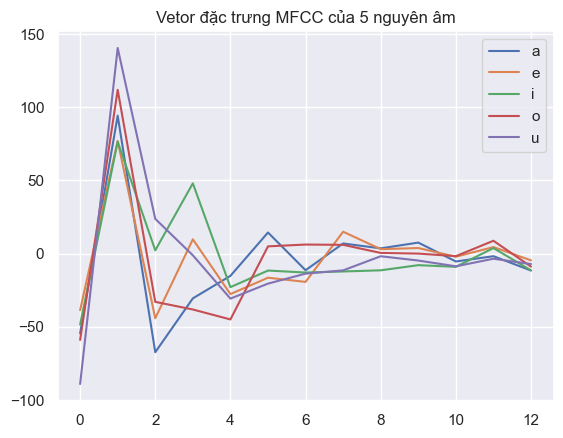

In [30]:
average_features = {
    "a": np.average(features["a"], axis=0),
    "e": np.average(features["e"], axis=0),
    "i": np.average(features["i"], axis=0),
    "o": np.average(features["o"], axis=0),
    "u": np.average(features["u"], axis=0),
}
# print(average_features['a'])
rows = []
for key, f in average_features.items():
    rows.append([key, f.reshape((N_MFCC,))])
plt.title("Vetor đặc trưng MFCC của 5 nguyên âm")
plt.plot(average_features["a"])
plt.plot(average_features["e"])
plt.plot(average_features["i"])
plt.plot(average_features["o"])
plt.plot(average_features["u"])
plt.legend(["a", "e", "i", "o", "u"])
# plt.savefig("MFCC_Features_Vector.png")
df = pd.DataFrame(rows)
df.to_csv("average_features_MFCC_13.csv", index=False)

In [31]:
#cài đặt Kmean lên tập features của từng nguyên âm, lấy tập centroids làm tập đặc trưng cho nguyên âm đó

#chọn ngẫu nhiên K hàng trong X làm tâm
def init_K(X, K):
    return X[np.random.choice(X.shape[0], K, replace=False)]

#duyệt tất cả các record và label tâm
def clustering(X, centroids):
    N = X.shape[0]
    label = np.zeros((1,N))
    for i in range (N):
        xi = X[i,:]
        min = np.linalg.norm(xi - centroids[0])
        for index, c in enumerate(centroids):
            if np.linalg.norm(xi - c) < min:
                min = np.linalg.norm(xi - c)
                label[0,i] = index
    return label

def cluster_of_same_label(index, label, X):
    selected = []
    for i in range(label.shape[1]):
        if label[0,i] == index:
            selected.append(X[i])
    return np.array(selected)

def isEqual(last_label, label):
    for i in range (label.shape[1]):
        if last_label[0,i] != label[0,i]:
            return False
    return True

def K_means(X, K, loop = 20):
    count = 0
    centroids = init_K(X,K)
    last_label = np.zeros((1,X.shape[0]))
    while (count < loop):
        label = clustering(X, centroids)
        #kiểm tra, nếu tập label không đổi => thoát
        if isEqual(last_label, label):
            return centroids, label
        new_centroids = np.zeros(centroids.shape)
        for index in range (centroids.shape[0]):
            new_centroids[index] = np.mean(cluster_of_same_label(index,label,X), axis = 0)
        centroids = new_centroids.copy()
        last_label = label
        count+=1
    return centroids, label


dim = N_MFCC
Kmeans_features = {
    'a': K_means(np.array(features['a']),K)[0], 
    'e': K_means(np.array(features['e']),K)[0],
    'i': K_means(np.array(features['i']),K)[0], 
    'o': K_means(np.array(features['o']),K)[0], 
    'u': K_means(np.array(features['u']),K)[0]
    }
print(Kmeans_features['a'])
print(Kmeans_features['a'].shape)

[[[-8.73381042e+01]
  [ 9.85267181e+01]
  [-2.35401649e+01]
  [-5.99713974e+01]
  [-2.35193920e+01]
  [ 3.43077164e+01]
  [-2.35587349e+01]
  [ 1.56659317e+01]
  [-8.85312855e-01]
  [ 1.01355581e+01]
  [-1.11175232e+01]
  [-2.00347733e+00]
  [-1.51924000e+01]]

 [[-4.39934883e+01]
  [ 1.01026314e+02]
  [-3.18946838e+01]
  [-3.38704643e+01]
  [-4.13069267e+01]
  [ 1.84229088e+01]
  [-5.64142799e+00]
  [ 1.17807913e+01]
  [ 6.69315681e-02]
  [ 1.61593990e+01]
  [-6.60624170e+00]
  [-1.42897356e+00]
  [-1.89175358e+01]]

 [[-6.07664986e+01]
  [ 8.79573898e+01]
  [-7.71146088e+01]
  [-4.10685730e+01]
  [-2.54833183e+01]
  [ 2.21936455e+01]
  [-1.85708504e+01]
  [ 1.35090513e+01]
  [ 4.69444656e+00]
  [ 7.46834421e+00]
  [-1.80051267e+00]
  [-8.04746056e+00]
  [-9.68372631e+00]]

 [[-5.19020386e+01]
  [ 1.10544350e+02]
  [-7.05549927e+01]
  [-2.58378487e+01]
  [ 1.71617031e+00]
  [ 2.26057458e+00]
  [-6.40580177e+00]
  [ 2.73400903e+00]
  [ 2.63955784e+00]
  [ 7.60217571e+00]
  [-7.44070482

In [32]:
#đọc dữ liệu kiểm thử
test_path = ".\\trimmed_signals\\KiemThu-16k"

tests = []

for file in sorted(os.listdir(test_path)):
    # print(os.path.join(path,file))
        sub_path = os.path.join(test_path,file)
        for sub_file in sorted(os.listdir(sub_path)):
            exact_test_path = os.path.join(sub_path,sub_file)
            audio, sr = get_stable_audio(exact_test_path)
            label = sub_file.split(".")[0]
            frames = windowing(audio, sr, frame_length, frame_hop)
            MFCCs = []
            for frame in frames:
                MFCCs.append(mfcc(frame,N_MFCC,sr))
            feature = np.average(MFCCs,axis=0)
            feature = feature/max(abs(feature))
            tests.append([feature,label]) # label này sẽ được sử dụng để kiểm tra kết quả nhận dạng

tests = np.array(tests)
print(tests)

[[array([[-0.31302035],
         [ 0.68187904],
         [-1.        ],
         [-0.33267853],
         [-0.7198858 ],
         [ 0.28265962],
         [-0.29246414],
         [-0.0112186 ],
         [ 0.18357766],
         [ 0.30223426],
         [-0.04454084],
         [-0.16344894],
         [ 0.02461572]], dtype=float32) 'a']
 [array([[-0.21946636],
         [ 0.6683923 ],
         [-1.        ],
         [ 0.07784884],
         [-0.86411744],
         [-0.12732425],
         [-0.81754404],
         [ 0.3840172 ],
         [ 0.2575701 ],
         [-0.00915566],
         [ 0.12922633],
         [ 0.31886914],
         [-0.26361844]], dtype=float32) 'e']
 [array([[-0.17887959],
         [ 1.        ],
         [-0.04408625],
         [ 0.82559174],
         [-0.52209324],
         [-0.48534364],
         [-0.31200624],
         [-0.18877965],
         [-0.53792053],
         [-0.06632993],
         [ 0.14555494],
         [-0.2272473 ],
         [-0.0950537 ]], dtype=float32) 'i']
 

C:\Users\This PC\AppData\Local\Temp\ipykernel_6984\2535876934.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tests = np.array(tests)


In [33]:
def classify(test_vectors, features):
    label_result = ""
    min_dist = 1e6
    for key, feature_set in features.items():
        for f in feature_set:
            dist = np.linalg.norm(test_vectors - f)
            if dist < min_dist:
                min_dist = dist
                label_result = key
    return label_result


count = 0
keys = {"a": 0, "e": 1, "i": 2, "o": 3, "u": 4}
table = np.zeros((5, 5))
startTime = time.time()
for test in tests:
    label_result = classify(test[0], Kmeans_features)
    if label_result == test[1]:
        count += 1
    table[keys[label_result], keys[test[1]]] += 1
    # print("Label: " + str(test[1]) + ", classified label: " + str(label_result))
endTime = time.time()
print("Thời gian nhận dạng", (endTime - startTime), "s")

Thời gian nhận dạng 0.01599264144897461 s


21
(1, 5)
   0     1     2   3      4
0  5  0.03  0.02  21  20.0%


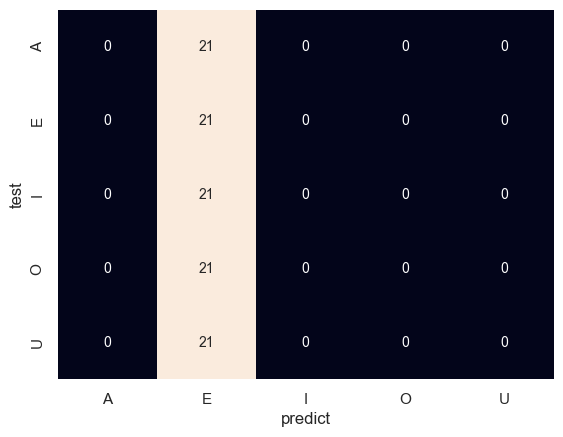

In [34]:
print(count)
Data = np.array([[K, frame_length, frame_hop, count, str(count/105*100) + "%"]])
Data = np.array(Data)
Data = Data.reshape(1, 5)
print(Data.shape)
# dfData = pd.DataFrame(Data, columns=["K", "frame_length", "frame_hop", "Count", "Percentage"], index=None)
dfData = pd.DataFrame(Data,columns=None ,index=None)
# dfData.to_csv("Test.csv", mode="a", index=False, header=False)
print(dfData)
# hiển thị bảng đúng sai
# từng hàng là label do chương trình nhận dạng
# từng cột là label đúng của dữ liệu
df_cm = pd.DataFrame(np.transpose(table), index=[i for i in "AEIOU"], columns=[i for i in "AEIOU"])
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cbar=False)
plt.xlabel("predict")
plt.ylabel("test")
# plt.savefig("ConfusionMatrix_K =" + str(K) + ".jpg")
plt.show()